In [1]:
from numpy.linalg import inv
from numpy.linalg import det
import numpy as np
from termcolor import colored
np.set_printoptions(precision=16)
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve
import time
import re
import os
from scipy.interpolate import griddata

In [4]:
import re
import numpy as np

def extract_node_matrix(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    node_matrix = []
    element_matrix = []

    reading_nodes = False
    reading_elements = False

    for line in lines:
        # Debug print statement
        # print(f"Processing line: {line.strip()}")

        # Case-insensitive search for 'Node'
        if re.search(r'\*node', line, re.IGNORECASE):
            reading_nodes = True
            reading_elements = False
            continue

        # Case-insensitive search for 'element'
        if re.search(r'\*element', line, re.IGNORECASE):
            if '*Element, type=CPE8R, elset=Visualization' in line:
                break  # Stop reading elements when this specific line is encountered
            reading_elements = True
            reading_nodes = False
            continue

        if reading_nodes and '*' in line:
            reading_nodes = False

        if reading_elements and '*' in line:
            reading_elements = False

        if reading_nodes:
            data = line.split(',')
            if data[0].strip().isdigit():
                node_id = int(data[0])
                coordinates = list(map(float, data[1:]))
                node_matrix.append([node_id] + coordinates)

        if reading_elements and ',' in line:
            data = line.split(',')
            if data[0].strip().isdigit():
                element_data = [int(val) for val in data]
                element_matrix.append(element_data)

    node_matrix = np.array(node_matrix)
    element_matrix = np.array(element_matrix)
    return node_matrix, element_matrix

def extract_boundary_nodes(file_path, nset_name):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    boundary_nodes = []

    reading_nodes = False

    for line in lines:
        if f'*Nset, nset={nset_name}' in line:
            reading_nodes = True
            continue  # Skip the line with "*Nset"

        if reading_nodes and '*' in line:
            break  # Stop reading nodes when another section starts

        if reading_nodes:
            data = line.split(',')
            nodes = [int(val) for val in data if val.strip().isdigit()]
            boundary_nodes.extend(nodes)

    return boundary_nodes

def side(SideName):
    ans = [i-1 for i in SideName]
    return ans

# Example usage:
file_name = 'SNIP.inp'
bottom_nodes = extract_boundary_nodes(file_name, 'BottomSide')
left_nodes = extract_boundary_nodes(file_name, 'LeftSide')
right_nodes = extract_boundary_nodes(file_name, 'RightSide')
top_nodes = extract_boundary_nodes(file_name, 'TopSide')
Crack_nodes=extract_boundary_nodes(file_name, 'Crack')

Nodes, Elements = extract_node_matrix(file_name)
Nodes = Nodes[:, 1:]  # Remove node IDs
Elements = Elements[:, 1:] - 1  # Remove element IDs and make zero-indexed

print("Nodes", Nodes)
print("Elements", Elements)

bottom_nodes = side(bottom_nodes)
left_nodes = side(left_nodes)
right_nodes = side(right_nodes)
top_nodes = side(top_nodes)
Crack_nodes=side(Crack_nodes)
boundary_nodes = np.unique(top_nodes + bottom_nodes + left_nodes + right_nodes+Crack_nodes)

NoE = len(Elements)  # Number of elements
NPE = len(Elements[0])  # Nodes per element
NoN = len(Nodes)  # Number of nodes
nqp = 4  # Integration points per element
DOF = 2  # Degrees of freedom

print("Number of elements:", NoE)
print("Nodes per element:", NPE)
print("Number of nodes:", NoN)
print("Boundary nodes:", boundary_nodes)
print("Crack_nodes:", Crack_nodes)

Nodes [[-0.5           0.          ]
 [ 0.            0.          ]
 [ 0.5           0.          ]
 ...
 [-0.0932270661 -0.0843826234]
 [ 0.229031533  -0.104724348 ]
 [ 0.346179962  -0.0633442029]]
Elements [[ 2615  2602   196 ...  5507  5508  5509]
 [ 2445   195   196 ...  5511  5507  5512]
 [  194   195  2445 ...  5510  5514  5515]
 ...
 [ 4424  4357  4449 ... 15160 15257 14942]
 [ 5472  4582  4626 ... 15408 15558 15412]
 [ 4575  5474  5476 ... 15419 15417 15527]]
Number of elements: 5409
Nodes per element: 8
Number of nodes: 16420
Boundary nodes: [    0     1     2     3     4     5     6     7     8     9    10    11
    12    13    14    15    16    17    18    19    20    21    22    23
    24    25    26    27    28    29    30    31    32    33    34   134
   135   136   137   138   139   140   141   142   143   144   145   146
   147   148   149   150   151   152   153   154   155   156   157   158
   159   160   161   162   163   164   165   166   167   168   169   170
   171

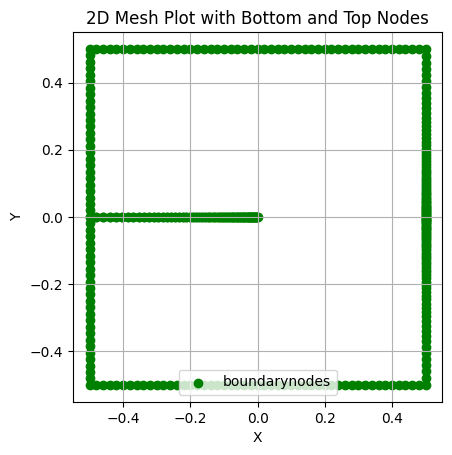

In [5]:
import matplotlib.pyplot as plt

# Plotting
plt.figure()

# Plot bottom nodes
# plt.scatter(Nodes[bottom_nodes, 0], Nodes[bottom_nodes, 1], c='r', marker='o', label='Bottom Nodes')

# Plot top nodes
plt.scatter(Nodes[boundary_nodes, 0], Nodes[boundary_nodes, 1], c='g', marker='o', label='boundarynodes')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Mesh Plot with Bottom and Top Nodes')
plt.grid(True)
plt.legend()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [6]:
Vh=2000 #mm3/mol
D=0.0127 #mm2/s
R=8314.5 #N.mm/mol-K
chita=0.89
T=300 #K
E = 210000 #MPa
v = 0.3
Gc= 2.7 #MPa-mm
el = 0.05 #mm
val=0.01 #mm
xkap = 1e-7  # Well-conditioning parameter
const=np.exp(-3e7 / (R * T))

C = (E/((1.0+v)*(1.0-2.0*v)) )* np.array([[1.0-v, v,v, 0.0], 
                                          [v, 1.0-v,v, 0.0],
                                          [v, v,1.0-v, 0.0],
                                          [0,0.0, 0.0, 0.5-v]])

In [7]:
get_elem_connectivity=[]
for element in Elements:
    dum=[]
    for i in element:
        dum.append(2*i)
        dum.append(2*i+1)
    get_elem_connectivity.append(dum)
w_qp = np.array([1, 1, 1, 1])
def get_w_qp():
    qp = np.array([[ 0.5774,  0.5774],
                    [ 0.5774, -0.5774],
                    [-0.5774,  0.5774],
                    [-0.5774, -0.5774]])
    return qp

def get_shape_function(z,n):
    N1 = (1 - z) * (1 - n)*(-1-z-n)/ 4
    N2 = (1 + z) * (1 - n) *(-1+z-n)/ 4
    N3 = (1 + z) * (1 + n) *(-1+z+n)/ 4
    N4 = (1 - z) * (1 + n) *(-1-z+n)/ 4
    N5 = (1 - z*z) * (1 - n)/ 2
    N6 = (1 + z) * (1 - n*n) / 2
    N7 = (1 - z*z) * (1 + n) / 2
    N8 = (1 - z) * (1 - n*n) / 2

    return np.array([[N1],[N2],[N3],[N4],[N5],[N6],[N7],[N8]])

def get_shape_function_derivative(z,n):
    dN1z =  (1 - n)*(n+2*z)/ 4
    dN1n =  (1 - z) * (z+2*n) / 4

    dN2z =  (1 - n)*(2*z-n)/ 4
    dN2n =  (1 + z) * (2*n-z) / 4

    dN3z =  (1 + n)*(2*z+n)/ 4
    dN3n =  (1 + z) * (2*n+z) / 4

    dN4z =  (1 + n)*(2*z-n)/ 4
    dN4n =  (1 - z) * (2*n-z) / 4

    dN5z =  -z* (1 - n)
    dN5n =  -(1 - z*z) / 2

    dN6z =  (1 - n*n) / 2
    dN6n =  -n* (1 +z)

    dN7z =  -z* (1 + n)
    dN7n =  (1 - z*z) / 2

    dN8z =  -(1 - n*n) / 2
    dN8n =  -n* (1 -z)

    return np.array([[dN1z,dN1n],[dN2z,dN2n],[dN3z,dN3n],[dN4z,dN4n],[dN5z,dN5n],[dN6z,dN6n],[dN7z,dN7n],[dN8z,dN8n]])

def Four_get_shape_function(xi, eta):
    # Quadrilateral element shape functions
    N = 1/4 * np.array([(1-xi)*(1-eta),
                        (1+xi)*(1-eta),
                        (1+xi)*(1+eta),
                        (1-xi)*(1+eta)])
    return N

N_vector=np.zeros((4,4))
qp=get_w_qp()
N_all=[]
for p in range(nqp):
        xi  = qp[p][0]
        eta = qp[p][1]
        N_vector[p]=Four_get_shape_function(xi,eta)
        N_all.append(get_shape_function(xi,eta))
N_vector_inv=inv(N_vector)

In [8]:
def compute_B_J_matrices(xi, eta, element_coord):
    dNdxi = get_shape_function_derivative(xi, eta)

    J = np.dot(np.transpose(dNdxi), element_coord)
    invJ = inv(J)
    dNdx = np.dot(invJ, np.transpose(dNdxi))

    B = np.zeros((4, 2*NPE))
    B[0, 0:2*NPE+1:2] = dNdx[0,:]
    B[1, 1:2*NPE+1:2] = dNdx[1,:]
    B[3, 0:2*NPE+1:2] = dNdx[1,:]
    B[3, 1:2*NPE+1:2] = dNdx[0,:]

    return B,dNdx, J

# Precompute B, J, and B_PF for all elements and quadrature points
def precompute_matrices(updated_coordinates):
    B_all = []
    J_all = []
    B_PF_all = []
    for i in range(NoE):
        element_coord = updated_coordinates[Elements[i]]
        B_elem = []
        J_elem = []
        B_PF_elem = []
        for p in range(nqp):
            xi, eta = qp[p]
            B,B_PF, J = compute_B_J_matrices(xi, eta, element_coord)
            B_elem.append(B)
            J_elem.append(np.linalg.det(J))
            B_PF_elem.append(B_PF)
        B_all.append(B_elem)
        J_all.append(J_elem)
        B_PF_all.append(B_PF_elem)
    return B_all, J_all, B_PF_all

In [9]:
def Disp_Stiffness_Matrix(C,phi,B_all, J_all):
    K = np.zeros((NoN*DOF, NoN*DOF))
    for i in range (NoE):
        K_elem = np.zeros((NPE*DOF, NPE*DOF))
        Le=get_elem_connectivity[i]
        phi_elem=phi[Elements[i]]
        B_elem = B_all[i]
        J_elem = J_all[i]
        for p in range(nqp):
            B = B_elem[p]
            detJ = J_elem[p]
            N=N_all[p]
            # update material property matrix
            C_degraded = ((1-np.dot(np.transpose(N),phi_elem))**2+ xkap) * C
            K_elem_qp = np.dot(np.dot(np.transpose(B), C_degraded), B) * w_qp[p] * detJ
            K_elem = K_elem + K_elem_qp
        K[np.ix_(Le, Le)] += K_elem
    return K


In [10]:
def compute_internal_forces(C,U,phi,history_energy,strain,stress,B_all, J_all):
    F_int = np.zeros((NoN*DOF))
    hydrostatic_stress=np.zeros((NoE,NPE,1))
    h=history_energy[-1] # previous step history energy
    for i in range (NoE):
        # print(num_idx,k)
        Le = get_elem_connectivity[i]
        u_elem = U[Le]
        phi_elem = phi[Elements[i]]
        B_elem = B_all[i]
        J_elem = J_all[i]
        # Loop over quadrature points to add their contribution to the global
        # internal forces vector
        F_int_elem = np.zeros((NPE*DOF))
        strain_total=np.zeros((nqp * 4))
        stress_total=np.zeros((nqp * 4))
        elas_str_ene=np.zeros((nqp , 1))
        HS=np.zeros((nqp , 1))
        for p in range(nqp):
            B = B_elem[p]
            detJ = J_elem[p]
            N=N_all[p]

            # update material property matrix
            C_degraded = ((1-np.dot(np.transpose(N),phi_elem))**2 + xkap) * C

            strain_total[p*4:(p+1)*4] += np.dot(B, u_elem)
            strain[i][p*4:(p+1)*4]=strain_total[p*4:(p+1)*4]
            stress_total[p*4:(p+1)*4] += np.dot(C_degraded, strain_total[p*4:(p+1)*4])
            # print("stress_total",stress_total)
            HS[p]=(stress_total[p*4]+stress_total[(p*4)+1]+stress_total[(p*4)+2])/3

            stress[i][p*4:(p+1)*4]=stress_total[p*4:(p+1)*4]

            elas_str_ene[p]=0.5*np.dot(np.dot(strain_total[p*4:(p+1)*4],C),strain_total[p*4:(p+1)*4])

            #Saving History energy term
            h[i][p]=max(h[i][p],elas_str_ene[p][0])
            # compute element internal forces at current qp
            F_int_elem_qp = np.dot(B.T, stress_total[p*4:(p+1)*4]) * w_qp[p] * detJ
            # print(F_int_elem_qp)
            F_int_elem = F_int_elem + F_int_elem_qp
        # print(F_int_elem)
        for k in range(len(Le)):
            F_int[Le[k]] = F_int[Le[k]] + F_int_elem[k]

        # update hydrostatic stress at nodes
        HSN = np.dot(N_vector_inv, HS)
        HS_at_nodes = np.zeros((NPE, 1))
        HS_at_nodes[:4, :] = HSN
        HS_at_nodes[4] = (HSN[0] + HSN[1]) / 2
        HS_at_nodes[5] = (HSN[1] + HSN[2]) / 2
        HS_at_nodes[6] = (HSN[2] + HSN[3]) / 2
        HS_at_nodes[7] = (HSN[3] + HSN[0]) / 2

        hydrostatic_stress[i] = HS_at_nodes
    return F_int,hydrostatic_stress,h

In [11]:
def Concentration_Residual(hydrostatic_stress,C_Hyderogen,J_all, B_PF_all):
    res_C=np.zeros((NoN,1))
    C_Hyderogen=C_Hyderogen.reshape((NoN,1))
    for i in range(NoE):
        res_C_elem=np.zeros((NPE,1))
        B_PF_elem = B_PF_all[i]
        J_elem = J_all[i]
        C_Hyderogen_elem=C_Hyderogen[Elements[i]]

        hydrostatic_stress_el=hydrostatic_stress[i]
        # print("hydrostatic_stress_el",hydrostatic_stress_el)

        for p in range(nqp):
            B_PF = B_PF_elem[p]
            detJ = J_elem[p]
            N=N_all[p]
            # print("B_PF",B_PF.shape)
            grad_C=np.dot(B_PF,C_Hyderogen_elem)
            # print("grad_C",grad_C.shape)
            C_elemN=np.dot(N.T,C_Hyderogen_elem)[0]
            # print("C_elemN",C_elemN)
            GradSigmaH=np.dot(B_PF,hydrostatic_stress_el)
            # print("GradSigmaH",GradSigmaH.shape)
            res_C_elem_qp=(np.dot(B_PF.T,grad_C)-np.dot(B_PF.T,(Vh*C_elemN/(R*T))*GradSigmaH))* w_qp[p] * detJ
            # print("res_C_elem_qp",res_C_elem_qp)
            res_C_elem = res_C_elem + res_C_elem_qp
            # print("res_C_elem",res_C_elem)
        res_C[Elements[i]]=res_C[Elements[i]]+res_C_elem
    return res_C

In [12]:
def Concentraion_stiffness_martix(hydrostatic_stress,J_all, B_PF_all):
    K_C = np.zeros((NoN, NoN))
    for i in range (NoE):
        K_C_elem = np.zeros((NPE, NPE))
        B_PF_elem = B_PF_all[i]
        J_elem = J_all[i]
        for p in range(nqp):
            B_PF = B_PF_elem[p]
            detJ = J_elem[p]
            N=N_all[p]
            # print("Gc0",Gc0)
            GradSigmaH=np.dot(B_PF,hydrostatic_stress[i])
            K_C_elem_qp=(np.dot(B_PF.T,B_PF)-np.dot(np.dot(B_PF.T,GradSigmaH)*(Vh/(R*T)),N.T))*(detJ*w_qp[p])
            # print("K_C_elem_qp",K_C_elem_qp.shape)
            K_C_elem = K_C_elem + K_C_elem_qp
        K_C[np.ix_(Elements[i], Elements[i])] = K_C[np.ix_(Elements[i], Elements[i])] + K_C_elem
    return K_C

In [13]:
def compute_PF_stiffness_matrix(h,C_Hyderogen,J_all, B_PF_all):
    K_phi=  np.zeros((NoN, NoN))
    for i in range (NoE):
        K_phi_elem = np.zeros((NPE, NPE))
        B_PF_elem = B_PF_all[i]
        J_elem = J_all[i]
        C_Hyderogen_elem=C_Hyderogen[Elements[i]]
        for p in range(nqp):
            B_PF = B_PF_elem[p]
            detJ = J_elem[p]
            N=N_all[p]

            # print("B_PF",B_PF)
            Eels=h[i][p]
            # print(p ," Eels",Eels)
            C_elemN=np.dot(N.T,C_Hyderogen_elem)[0]
            # print("C_elemN",C_elemN)
            Theta = C_elemN* 5.5e-05 / (C_elemN * 5.5e-05 + const)
            Gc0 = Gc * (1.0 - 0.89 * Theta)
               
            K_phi_elem_qp = (Gc0/el * np.dot(N, N.T) + \
                                 Gc0*el * np.dot(B_PF.T, B_PF) + \
                                 2*Eels * np.dot(N, N.T)) \
                                 * w_qp[p] * detJ

            K_phi_elem = K_phi_elem + K_phi_elem_qp
        # print("K_phi_elem",K_phi_elem)
        K_phi[np.ix_(Elements[i], Elements[i])] = K_phi[np.ix_(Elements[i], Elements[i])] + K_phi_elem

    return K_phi

In [14]:
def compute_PF_residual(phi,C_Hyderogen,h,J_all,B_PF_all):
    res_phi=np.zeros((NoN,1))
    for i in range (NoE):
        phi_elem = phi[Elements[i]]
        res_phi_elem=np.zeros((NPE,1))
        J_elem = J_all[i]
        B_PF_elem = B_PF_all[i]
        C_Hyderogen_elem=C_Hyderogen[Elements[i]]
        # Loop over quadrature points to add their contribution to the global
        # internal forces vector
        for p in range(nqp):
            B_PF = B_PF_elem[p]
            detJ = J_elem[p]
            N=N_all[p]

            # print("B_PF",B_PF)
            Eels=h[i][p]
            # print(p ," Eels",Eels)
            C_elemN=np.dot(N.T,C_Hyderogen_elem)[0]
            # print("C_elemN",C_elemN)
            Theta = C_elemN* 5.5e-05 / (C_elemN * 5.5e-05 + const)
            Gc0 = Gc * (1.0 - 0.89 * Theta)
            # print("Gc0",Gc0)
            # compute element internal forces at current qp
            phi_N=np.dot(N.T,phi_elem)[0]
            
            res_phi_elem_qp=((Gc0/el *phi_N*N)+Gc0*el *np.dot(np.dot(B_PF.T, B_PF), phi_elem)+2*Eels*phi_N*N-2*Eels * N)*w_qp[p]*detJ

            res_phi_elem = res_phi_elem + res_phi_elem_qp

        res_phi[Elements[i]] = res_phi[Elements[i]] + res_phi_elem
    return res_phi

In [15]:

### Boundary condition arrays
blocked = np.zeros((NoN*DOF))
u_bar = np.zeros((NoN*DOF))

# Iterating over top_nodes_list (apply top y-displacement)
comp = 2
val = 0.01
for i in range(len(top_nodes)):
    node_number = top_nodes[i]
    blocked[2*(node_number)+comp-1] = 1
    u_bar[2*(node_number)+comp-1] = val

# Iterating over bottom_nodes_list (apply bottom x-fix)
comp = 1
val = 0.0
for i in range(len(bottom_nodes)):
    node_number = bottom_nodes[i]
    blocked[2*(node_number)+comp-1] = 1
    u_bar[2*(node_number)+comp-1] = val

# Iterating over bottom_nodes_list (apply bottom y-fix)
comp = 2
val = 0.0
for i in range(len(bottom_nodes)):
    node_number = bottom_nodes[i]
    blocked[2*(node_number)+comp-1] = 1
    u_bar[2*(node_number)+comp-1] = val
print("u_bar",u_bar)
print("blocked",blocked)

u_bar [0. 0. 0. ... 0. 0. 0.]
blocked [0. 0. 0. ... 0. 0. 0.]


In [16]:
# apply concentraion boundary condition
Blocked_C=np.zeros((NoN))
C_bar=np.zeros((NoN))
C0=1.0

for i in range(len(boundary_nodes)):
    node_number = boundary_nodes[i]
    Blocked_C[node_number] = 1
    C_bar[node_number] = C0
print("C_bar",C_bar)
print("Blocked_C",Blocked_C)

C_bar [1. 1. 1. ... 0. 0. 0.]
Blocked_C [1. 1. 1. ... 0. 0. 0.]


In [17]:
# Construct the external force vector
F_ext = np.zeros(NoN*DOF)

# Construct the reaction force vector
R_ext = np.zeros((NoN*DOF))

##############################################################################
# Construct displacement related variables
U = np.zeros((NoN*DOF,1))
dU = np.zeros((NoN*DOF,1))
K=  np.zeros((NoN*DOF, NoN*DOF))
res = np.zeros((NoN*DOF,1))

# Construct PF (phase field) related variables
strain=np.zeros((NoE,nqp , 4))
stress=np.zeros((NoE,nqp , 4))
h=np.zeros((NoE,nqp))
history_energy=[]
history_energy.append(h)
K_phi = np.zeros((NoN, NoN))
res_phi = np.zeros((NoN,1))
phi = np.zeros((NoN,1))
dphi = np.zeros((NoN,1))


#construct concentraion related variables
hydrostatic_stress_global_step=[]
hydrostatic_stress=np.zeros((NoE,NPE,1))
hydrostatic_stress_global_step.append(hydrostatic_stress)
C_Hyderogen=np.zeros((NoN,1))
C_at_each_step=[]
C_at_each_step.append(C_Hyderogen)
K_C=np.zeros((NoN, NoN))
res_C=np.zeros((NoN,1))
F_int_C=np.zeros((NoN,1))
F_ext_C = np.zeros((NoN,1))
R_ext_C = np.zeros((NoN,1))
##############################################################################
def function_update_node_coordinates(U):
    updated_coordinate = Nodes + U.reshape((-1, 2))
    return updated_coordinate

In [18]:
# Record values during the solution process
R_ext_values = []
F_int_values = []
U_values = []
U_values.append(U)
strain_values = []
stress_values = []
phi_values = []
##############################################################################
# Iterative solve of the equilibruim equation
# Newton Raphson Method
F_int = np.zeros(NoN*DOF)
F_ext_ = np.zeros(NoN*DOF)
u_bar_ = np.zeros(NoN*DOF)

In [19]:
# Create a folder to store the images
output_folder = 'displacement_Contour_Plot'
os.makedirs(output_folder, exist_ok=True)

# Function to create a contour plot and save it as an image
def create_displacement_contour_plot_and_save(U,updated_coordinates,pl, output_folder='displacement_Contour_Plot'):
    # Nodes contains [X, Y] coordinates
    X = updated_coordinates[:, 0]
    Y = updated_coordinates[:, 1]
    U_magnitude = np.sqrt(U[::2]**2 + U[1::2]**2)  # Assuming U is flattened [Ux0, Uy0, Ux1, Uy1, ...]
    # print(phi)
    # Define grid.
    xi = np.linspace(X.min(), X.max(), 100)
    yi = np.linspace(Y.min(), Y.max(), 100)
    xi, yi = np.meshgrid(xi, yi)

    # Interpolate U onto this regular grid.
    zi = griddata((X, Y), U_magnitude, (xi, yi), method='linear')

    # Contour plot
    plt.figure(figsize=(10, 10))
    plt.contourf(xi, yi, zi, levels=50, cmap='jet')
    plt.colorbar(label='displacement magnitude')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('displacement Contour Plot')
    # plt.show()
    # Save the plot as an image
    output_path = os.path.join(output_folder, f'displacement_Contour_Plot_step_{pl}.png')
    plt.savefig(output_path)
    plt.close()  # Close the plot to avoid displaying it in the notebook

    print(f'Plot saved: {output_path}')

In [20]:
# Create a folder to store the images
output_folder = 'Phase_Field_Contour_plot'
os.makedirs(output_folder, exist_ok=True)

# Function to create a contour plot and save it as an image
def create_phi_contour_plot_and_save(phi,updated_coordinates,pl, output_folder='Phase_Field_Contour_plot'):
    # Nodes contains [X, Y] coordinates
    # Define grid.
    xi = np.linspace(updated_coordinates[:, 0].min(), updated_coordinates[:, 0].max(), 100)
    yi = np.linspace(updated_coordinates[:, 1].min(), updated_coordinates[:, 1].max(), 100)
    xi, yi = np.meshgrid(xi, yi)

    # Interpolate phi onto this regular grid.
    zi = griddata((updated_coordinates[:, 0], updated_coordinates[:, 1]), phi, (xi, yi), method='linear')
    zi = zi.reshape(xi.shape)

    # Contour plot
    plt.figure(figsize=(10, 8))
    contour = plt.contourf(xi, yi, zi, levels=50, cmap='viridis')
    plt.colorbar(label='Phase Field (phi)')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Phase Field Contour Plot')

    # Find the maximum value of phi and its corresponding coordinates
    max_phi = np.max(phi)
    max_phi_index = np.argmax(phi)

    max_phi_coords = (updated_coordinates[max_phi_index, 0], updated_coordinates[max_phi_index, 1])

    # Plot the maximum value of phi with a point on the plot
    # plt.plot(max_phi_coords[0], max_phi_coords[1], 'ro', markersize=10, label=f'Max Phi: {max_phi}')

    # plt.legend()
    # plt.show()
    # Save the plot as an image
    output_path = os.path.join(output_folder, f'Phase_Field_Contour_Plot_step_{pl}.png')
    plt.savefig(output_path)
    plt.close()  # Close the plot to avoid displaying it in the notebook

    print(f'Plot saved: {output_path}')

In [21]:
# Create a folder to store the images
output_folder = 'hydrogen concentration contour plot'
os.makedirs(output_folder, exist_ok=True)

# Function to create a contour plot and save it as an image
def create_concentration_contour_plot_and_save(C_Hyderogen,updated_coordinates,pl, output_folder='hydrogen concentration contour plot'):
    # Nodes contains [X, Y] coordinates
    X = updated_coordinates[:, 0]
    Y = updated_coordinates[:, 1]

    # Define grid.
    xi = np.linspace(X.min(), X.max(), 100)
    yi = np.linspace(Y.min(), Y.max(), 100)
    xi, yi = np.meshgrid(xi, yi)

    # Interpolate C_Hyderogen onto this regular grid.
    zi = griddata((X, Y), C_Hyderogen, (xi, yi), method='linear')

    # Contour plot
    plt.figure(figsize=(10, 8))
    contour = plt.contourf(xi, yi, zi, levels=50, cmap='viridis')
    plt.colorbar(label='hydrogen concentration')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('hydrogen concentration contour plot')

    
    # Save the plot as an image
    output_path = os.path.join(output_folder, f'hydrogen_concentration_contour_plot{pl}.png')
    plt.savefig(output_path)
    plt.close()  # Close the plot to avoid displaying it in the notebook

    print(f'Plot saved: {output_path}')

In [22]:
num_load_steps = 1000
itr_max = 1000
itr_tol = 1E-5
for l in range(num_load_steps):

    #=====================================================================
    # update essential and neumann boundary conditions
    u_bar_ += 1/num_load_steps * u_bar
    F_ext_ += 1/num_load_steps * F_ext

    #=====================================================================
    updated_coordinates=function_update_node_coordinates(U)
    # Precompute matrices
    B_all, J_all, B_PF_all = precompute_matrices(updated_coordinates)
    # update stiffness matrix of the displacement governing equation
    K=Disp_Stiffness_Matrix(C,phi,B_all, J_all)
    # print(K)
    #=====================================================================
    # compute residual of the displacement governing equation
    res = F_ext_ + R_ext - F_int

    #=====================================================================
    # Impose essential boundary conditions
    K_temp = np.copy(K)
    for m in range(NoN*DOF):
        if(blocked[m]==1):
            for n in range(NoN*DOF):
                if(blocked[n]==0):
                    res[n] -= K[n,m] * u_bar_[m]
            K_temp[m,:] = 0.0
            K_temp[:,m] = 0.0
            K_temp[m,m] = 1.0
            res[m] = u_bar_[m]
    # print("res",res)
    #=====================================================================
    # Loop on iterations for the DISPLACEMENT governing equation
    max_itr_reached = False
    K_temp_csc = csc_matrix(K_temp)
    for k in range(itr_max):

        # calculate displacement vector increment

        U = spsolve(K_temp_csc, res)
        # print(U)
        # update the reaction forces

        for m in range(NoN*DOF):
            if(blocked[m]==1):
                R_ext[m] = np.dot(K[m,:], U)
        # print(R_ext)
        # compute internal forces vector ,hydrostatic stress and update history energy
        F_int,hydrostatic_stress,h= compute_internal_forces(C,U,phi,history_energy,strain,stress,B_all, J_all)

        # print("F_int",F_int)
        # update residual and check convergence
        res = F_ext_ + R_ext - F_int
        tol = np.linalg.norm(res)/np.linalg.norm(F_ext_ + R_ext)
        # printing iteration information
        print("Load step {} - Iteration {} - tolerance = {}".format(l+1, k+1, tol))
        if (tol < itr_tol):
            print(colored("Displacement solve converged!", 'green'))
            # Record of all at each load step
            history_energy.append(h)
            hydrostatic_stress_global_step.append(hydrostatic_stress)
            # R_ext_values.append(R_ext)
            F_int_values.append(F_int)
            U_values.append(U)
            create_displacement_contour_plot_and_save(U,updated_coordinates,l, output_folder='displacement_Contour_Plot')
            strain_values.append(strain)
            stress_values.append(stress)
            break # break out of the iteration loop to the next load step
        if (k == itr_max-1):
            print("Maximum number of iteration in displacement solve is reached!")
            print("Displacement solve did NOT converge!")
            max_itr_reached = True
            break # break out of the iteration loop
    if(max_itr_reached):
        break # break out of the load step loop
    
    # compute residual of the PF (phase field) governing equation
    h=history_energy[-2]

    res_phi = compute_PF_residual(phi,C_Hyderogen,h,J_all,B_PF_all)
    # print("res_phi",res_phi)

    # update stiffness matrix of the PF (phase field) governing equation
    K_phi = compute_PF_stiffness_matrix(h,C_Hyderogen,J_all,B_PF_all)
    # print("K_phi",K_phi)
    K_phi_csc = csc_matrix(K_phi)
    for k in range(itr_max):
        # calculate phase field vector increment

        dphi = spsolve(K_phi_csc, -res_phi)
        # print("dphi",dphi)
        dphi = dphi.reshape((NoN,1))
        # print("dphi",dphi)
     
        # update the phase field vector
        phi = phi + dphi
        # print("phi",phi)
        res_phi = compute_PF_residual(phi,C_Hyderogen,h,J_all,B_PF_all)
        # print(res_phi)
        tol_phi = np.linalg.norm(res_phi)
        #  printing iteration information
        print("Phase field solve step {} - Iteration {} - tolerance = {}".format(l+1, k+1, tol_phi))
        if (tol_phi < itr_tol):
            print(colored("Phase field solve converged!", 'green'))
            # Record of all at each load step
            phi_values.append(phi)
            create_phi_contour_plot_and_save(phi,updated_coordinates,l, output_folder='Phase_Field_Contour_plot')

            break # break out of the iteration loop to the next load step
        if (k == itr_max-1):
            print("Maximum number of iteration in Phase field solve is reached!")
            print("Phase field solve did NOT converge!")
            max_itr_reached = True
            break # break out of the iteration loop

    if(max_itr_reached):
        break # break out of the load step loop
    
    hydrostatic_stress=hydrostatic_stress_global_step[-2]

    K_C=Concentraion_stiffness_martix(hydrostatic_stress,J_all, B_PF_all)
    # print("K_C",K_C)
    res_C=F_ext_C+R_ext_C-F_int_C
    # print("res_C",res_C)
    K_C_temp = np.copy(K_C)
    for m in range(NoN):
        if(Blocked_C[m]==1):
            for n in range(NoN):
                if(Blocked_C[n]==0):
                    res_C[n] -= K_C[n,m] * C_bar[m]
            K_C_temp[m,:] = 0.0
            K_C_temp[:,m] = 0.0
            K_C_temp[m,m] = 1.0
            res_C[m] = C_bar[m]
    K_C_csc = csc_matrix(K_C_temp)
    # print("res_C",res_C)
    # C_previous=C_at_each_step[-1]
    for k in range(itr_max):
        C_Hyderogen= spsolve(K_C_csc, res_C)
        # print(f"Step: {l+1}, ITR: {k+1} C_Hyderogen",C_Hyderogen)
        for m in range(NoN):
            if(Blocked_C[m]==1):
                R_ext_C[m] = np.dot(K_C[m,:], C_Hyderogen)
        # print(f"{l+1} R_ext_C",R_ext_C)
        # C_Hyderogen=C_Hyderogen+dC_Hyderogen
        F_int_C=Concentration_Residual(hydrostatic_stress,C_Hyderogen,J_all, B_PF_all)

        res_C=F_ext_C+R_ext_C-F_int_C

        tol_C=np.linalg.norm(res_C)

        # C_previous=C_Hyderogen
        # tol_C = np.linalg.norm(res_C)
        # printing iteration information
        print("Load step {} - Iteration {} - tolerance = {}".format(l+1, k+1, tol_C))
        if (tol_C < itr_tol):
            print(colored("Concentration solve converged!", 'green'))
            C_at_each_step.append(C_Hyderogen)
            
            create_concentration_contour_plot_and_save(C_Hyderogen,updated_coordinates,l, output_folder='hydrogen concentration contour plot')
            break # break out of the iteration loop to the next load step
        if (k == itr_max-1):
            print("Maximum number of iteration in concentration solve is reached!")
            print("Concentration solve did NOT converge!")
            max_itr_reached = True
            break # break out of the iteration loop
    if(max_itr_reached):
        break # break out of the load step loop
    #=====================================================================     

Load step 1 - Iteration 1 - tolerance = 6.60169123350329e-13
Displacement solve converged!
Plot saved: displacement_Contour_Plot\displacement_Contour_Plot_step_0.png
Phase field solve step 1 - Iteration 1 - tolerance = 1.3204140541535826e-20
Phase field solve converged!
Plot saved: Phase_Field_Contour_plot\Phase_Field_Contour_Plot_step_0.png
Load step 1 - Iteration 1 - tolerance = 1.9473582704959945e-13
Concentration solve converged!
Plot saved: hydrogen concentration contour plot\hydrogen_concentration_contour_plot0.png
Load step 2 - Iteration 1 - tolerance = 7.232748049479694e-13
Displacement solve converged!
Plot saved: displacement_Contour_Plot\displacement_Contour_Plot_step_1.png
Phase field solve step 2 - Iteration 1 - tolerance = 4.77411815923126e-20
Phase field solve converged!
Plot saved: Phase_Field_Contour_plot\Phase_Field_Contour_Plot_step_1.png
Load step 2 - Iteration 1 - tolerance = 2.71556990657161e-13
Concentration solve converged!
Plot saved: hydrogen concentration con

In [39]:
print("phi shape", phi.shape)
print("C_hydrogen shape", C_Hyderogen.shape)
print("Elemnets[0] ", Elements[0])
print("Nodes [0]", Nodes)
print("phi ", phi.shape)


phi shape (16420, 1)


In [43]:
import numpy as np
import os

def write_vtk(path, step, nodes, elements, displacement, phi, concentration):
    num_nodes = nodes.shape[0]
    num_elements = elements.shape[0]

    # Ensure the output directory exists
    os.makedirs(path, exist_ok=True)
    filename = os.path.join(path, f'out-{step}.vtu')

    with open(filename, 'w') as f:
        f.write('<VTKFile type="UnstructuredGrid" version="0.1" byte_order="LittleEndian">\n')
        f.write('\t<UnstructuredGrid>\n')
        f.write(f'\t\t<Piece NumberOfPoints="{num_nodes}" NumberOfCells="{num_elements}">\n')

        # Points section
        f.write('\t\t\t<Points>\n')
        f.write('\t\t\t\t<DataArray type="Float32" NumberOfComponents="3" Format="ascii">\n')
        for node in nodes:
            f.write(f'\t\t\t\t\t{node[0]} {node[1]} 0.0\n')
        f.write('\t\t\t\t</DataArray>\n')
        f.write('\t\t\t</Points>\n')

        # Cells section
        f.write('\t\t\t<Cells>\n')
        f.write('\t\t\t\t<DataArray type="Int32" Name="connectivity" Format="ascii">\n')
        for element in elements:
            f.write('\t\t\t\t\t' + ' '.join(map(str, element)) + '\n')
        f.write('\t\t\t\t</DataArray>\n')

        f.write('\t\t\t\t<DataArray type="Int32" Name="offsets" Format="ascii">\n')
        offset = 0
        for element in elements:
            offset += len(element)
            f.write(f'\t\t\t\t\t{offset}\n')
        f.write('\t\t\t\t</DataArray>\n')

        f.write('\t\t\t\t<DataArray type="UInt8" Name="types" Format="ascii">\n')
        for _ in elements:
            f.write('\t\t\t\t\t9\n')  # VTK_QUAD cell type
        f.write('\t\t\t\t</DataArray>\n')
        f.write('\t\t\t</Cells>\n')

        # Point data section
        f.write('\t\t\t<PointData Scalars="scalars">\n')

        # Compute displacement magnitude
        U_magnitude = np.sqrt(displacement[::2]**2 + displacement[1::2]**2)

        f.write('\t\t\t\t<DataArray type="Float32" Name="displacement_magnitude" NumberOfComponents="1" Format="ascii">\n')
        for val in U_magnitude:
            f.write(f'\t\t\t\t\t{val}\n')
        f.write('\t\t\t\t</DataArray>\n')

        f.write('\t\t\t\t<DataArray type="Float32" Name="UX" NumberOfComponents="1" Format="ascii">\n')
        for val in displacement[::2]:
            f.write(f'\t\t\t\t\t{val}\n')
        f.write('\t\t\t\t</DataArray>\n')

        f.write('\t\t\t\t<DataArray type="Float32" Name="UY" NumberOfComponents="1" Format="ascii">\n')
        for val in displacement[1::2]:
            f.write(f'\t\t\t\t\t{val}\n')
        f.write('\t\t\t\t</DataArray>\n')

        f.write('\t\t\t\t<DataArray type="Float32" Name="phi" NumberOfComponents="1" Format="ascii">\n')
        for val in phi:
            f.write(f'\t\t\t\t\t{val}\n')
        f.write('\t\t\t\t</DataArray>\n')

        f.write('\t\t\t\t<DataArray type="Float32" Name="concentration" NumberOfComponents="1" Format="ascii">\n')
        for val in concentration:
            f.write(f'\t\t\t\t\t{val}\n')
        f.write('\t\t\t\t</DataArray>\n')

        f.write('\t\t\t</PointData>\n')

        f.write('\t\t</Piece>\n')
        f.write('\t</UnstructuredGrid>\n')
        f.write('</VTKFile>\n')

    print(f'VTK file written: {filename}')

# Example usage:
# Assuming you have the variables `Nodes`, `Elements`, `U_values`, `phi_values`, and `C_at_each_step` from your code

output_folder_vtk = 'VTK_files2'
os.makedirs(output_folder_vtk, exist_ok=True)

for step, (U_step, phi_step, C_step) in enumerate(zip(U_values, phi_values, C_at_each_step)):
    write_vtk(output_folder_vtk, step, updated_coordinates, Elements, U_step.flatten(), phi_step.flatten(), C_step.flatten())
    print(f'VTK file written: step_{step}')


VTK file written: VTK_files2\out-0.vtu
VTK file written: step_0
VTK file written: VTK_files2\out-1.vtu
VTK file written: step_1
VTK file written: VTK_files2\out-2.vtu
VTK file written: step_2
VTK file written: VTK_files2\out-3.vtu
VTK file written: step_3
VTK file written: VTK_files2\out-4.vtu
VTK file written: step_4
VTK file written: VTK_files2\out-5.vtu
VTK file written: step_5
VTK file written: VTK_files2\out-6.vtu
VTK file written: step_6
VTK file written: VTK_files2\out-7.vtu
VTK file written: step_7
VTK file written: VTK_files2\out-8.vtu
VTK file written: step_8
VTK file written: VTK_files2\out-9.vtu
VTK file written: step_9
VTK file written: VTK_files2\out-10.vtu
VTK file written: step_10
VTK file written: VTK_files2\out-11.vtu
VTK file written: step_11
VTK file written: VTK_files2\out-12.vtu
VTK file written: step_12
VTK file written: VTK_files2\out-13.vtu
VTK file written: step_13
VTK file written: VTK_files2\out-14.vtu
VTK file written: step_14
VTK file written: VTK_files2\o

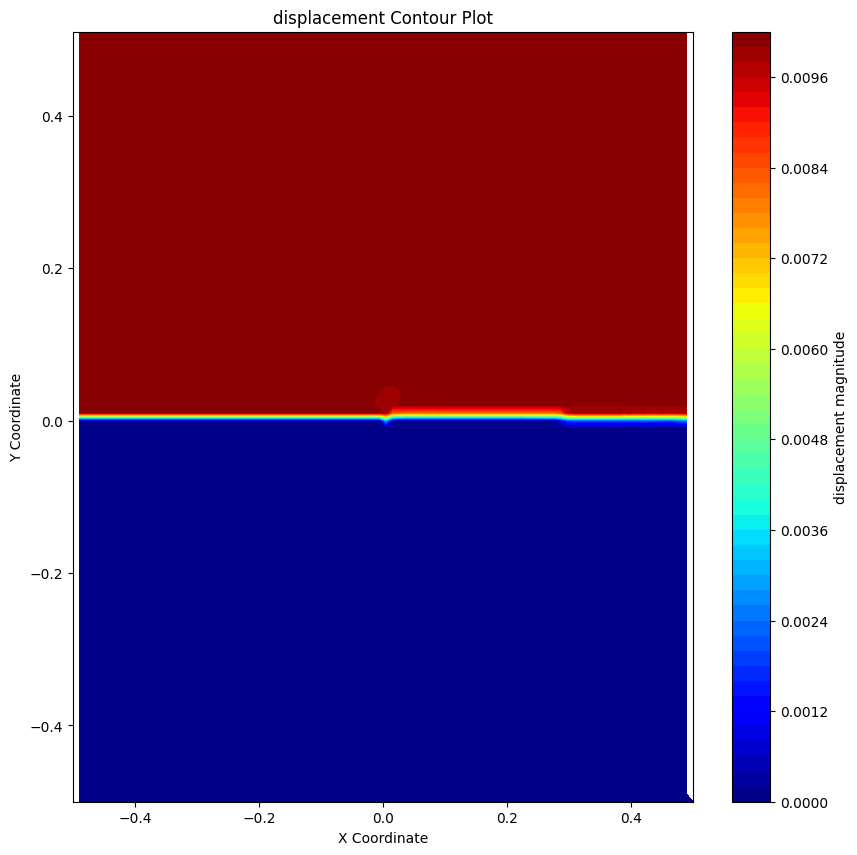

In [23]:
from scipy.interpolate import griddata
# Nodes contains [X, Y] coordinates
X = updated_coordinates[:, 0]
Y = updated_coordinates[:, 1]

# Assuming U contains displacement magnitudes at each node
# If U is in the form [Ux, Uy] per node, compute magnitude as:
# U_magnitude = np.sqrt(U[:, 0]**2 + U[:, 1]**2)

U_magnitude = np.sqrt(U[::2]**2 + U[1::2]**2)  # Assuming U is flattened [Ux0, Uy0, Ux1, Uy1, ...]
# print(phi)
# Define grid.
xi = np.linspace(X.min(), X.max(), 100)
yi = np.linspace(Y.min(), Y.max(), 100)
xi, yi = np.meshgrid(xi, yi)

# Interpolate U onto this regular grid.
zi = griddata((X, Y), U_magnitude, (xi, yi), method='linear')

# Contour plot
plt.figure(figsize=(10, 10))
plt.contourf(xi, yi, zi, levels=50, cmap='jet')
plt.colorbar(label='displacement magnitude')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('displacement Contour Plot')
plt.show()


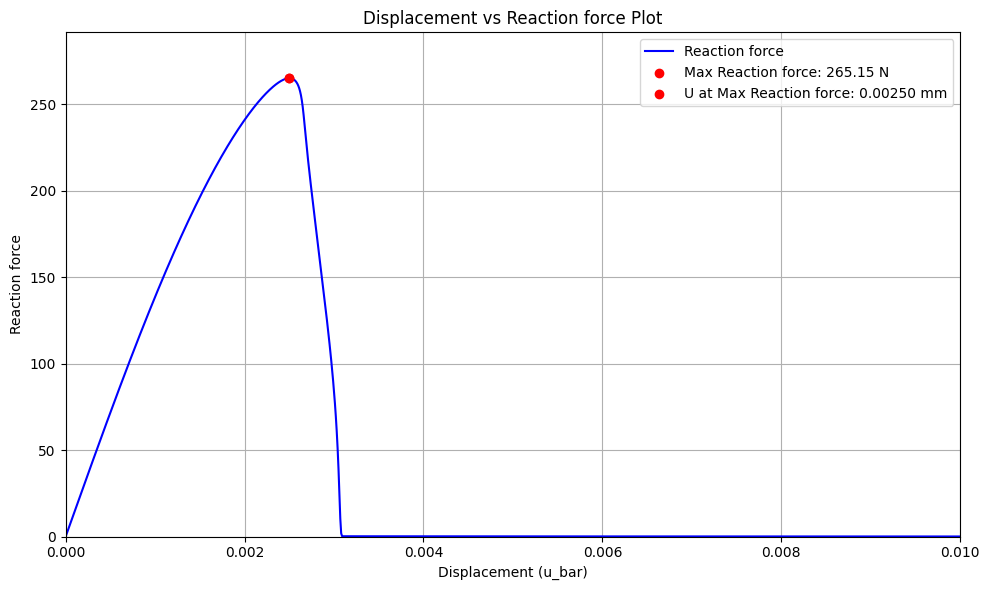

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_reaction_force(force, bottom_nodes):
    R_ext_X = force[[2 * i for i in bottom_nodes]]
    R_ext_Y = force[[2 * i + 1 for i in bottom_nodes]]
    R_ext_resultant = np.sqrt(R_ext_X ** 2 + R_ext_Y ** 2)
    return R_ext_resultant

# Assuming F_int_values, bottom_nodes, and num_load_steps are defined

R_ext_bottom_array = [0]
for force in F_int_values:
    R_ext_bottom_array.append(sum(calculate_reaction_force(force, bottom_nodes)))

# Create a linspace for U_step
U_step = np.linspace(0.0, 0.01, num_load_steps + 1)
U_step = U_step[0:len(R_ext_bottom_array)]
max_index = np.argmax(R_ext_bottom_array)
max_value = R_ext_bottom_array[max_index]
max_U_step = U_step[max_index]

# Save the plot values to a text file
np.savetxt('plot_values.txt', np.column_stack((U_step, R_ext_bottom_array)), header='U_step\tR_ext_bottom_array', comments='')

# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(U_step, R_ext_bottom_array, label='Reaction force', color='blue')

# Mark the maximum value
plt.scatter(max_U_step, max_value, color='red', label=f'Max Reaction force: {max_value:.2f} N', zorder=5)
plt.scatter(max_U_step, max_value, color='red', label=f'U at Max Reaction force: {max_U_step:.5f} mm', zorder=5)

plt.xlim(0, max(U_step))
plt.ylim(0, 1.1 * max(R_ext_bottom_array))
plt.xlabel('Displacement (u_bar)')
plt.ylabel('Reaction force')
plt.title('Displacement vs Reaction force Plot')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


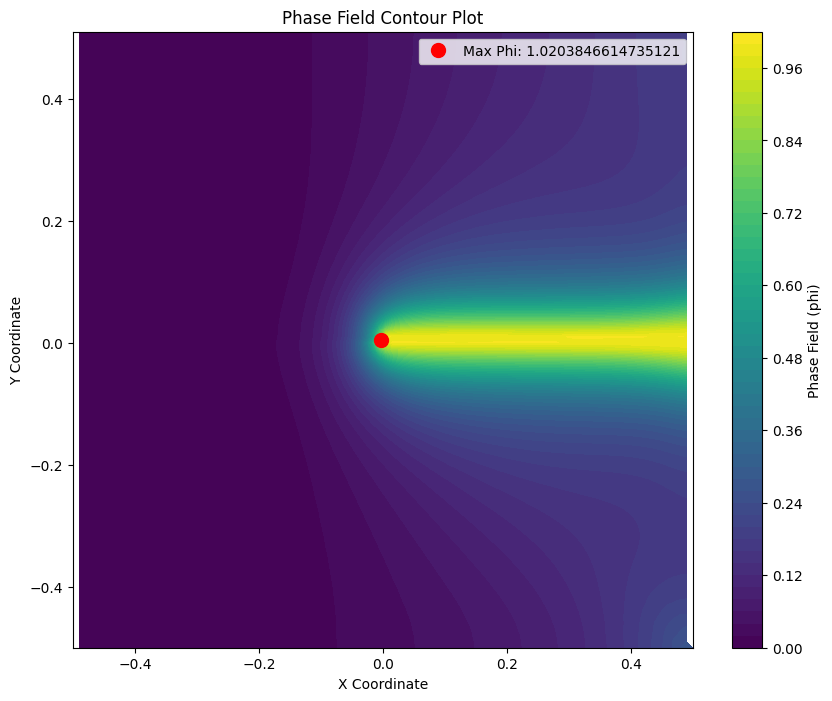

In [25]:
import numpy as np
import matplotlib.pyplot as plt
phi=phi_values[-1]

# Your data and calculations...
# Assuming updated_coordinates and phi are defined

# Define grid.
xi = np.linspace(updated_coordinates[:, 0].min(), updated_coordinates[:, 0].max(), 100)
yi = np.linspace(updated_coordinates[:, 1].min(), updated_coordinates[:, 1].max(), 100)
xi, yi = np.meshgrid(xi, yi)

# Interpolate phi onto this regular grid.
zi = griddata((updated_coordinates[:, 0], updated_coordinates[:, 1]), phi, (xi, yi), method='linear')
zi = zi.reshape(xi.shape)

# Contour plot
plt.figure(figsize=(10, 8))
contour = plt.contourf(xi, yi, zi, levels=50, cmap='viridis')
plt.colorbar(label='Phase Field (phi)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Phase Field Contour Plot')

# Find the maximum value of phi and its corresponding coordinates
max_phi = np.max(phi)
max_phi_index = np.argmax(phi)

max_phi_coords = (updated_coordinates[max_phi_index, 0], updated_coordinates[max_phi_index, 1])

# Plot the maximum value of phi with a point on the plot
plt.plot(max_phi_coords[0], max_phi_coords[1], 'ro', markersize=10, label=f'Max Phi: {max_phi}')

plt.legend()

plt.show()

Max C: 1.0369115252418217


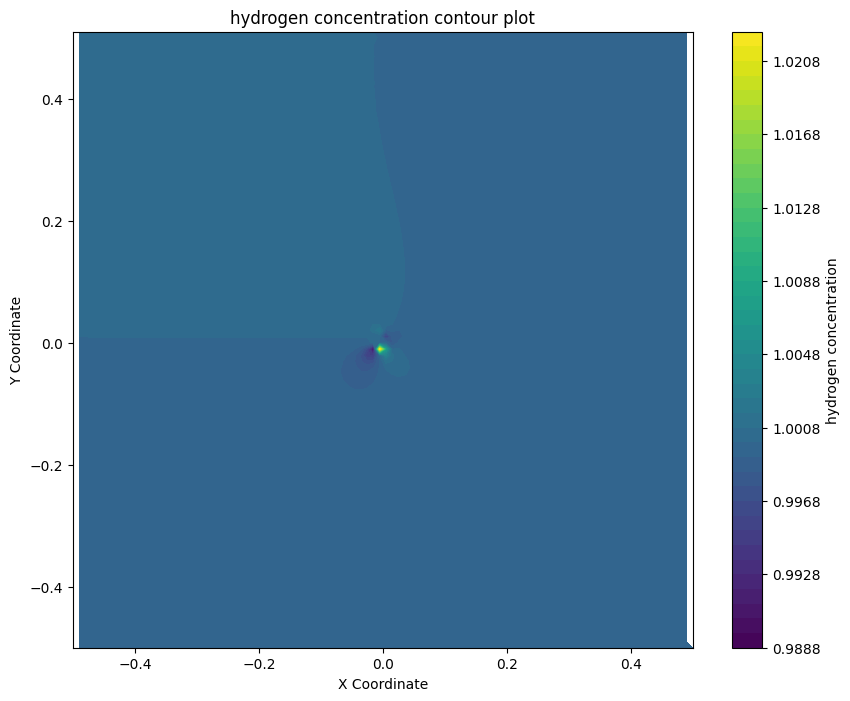

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Nodes contains [X, Y] coordinates
X = updated_coordinates[:, 0]
Y = updated_coordinates[:, 1]

# Define grid.
xi = np.linspace(X.min(), X.max(), 100)
yi = np.linspace(Y.min(), Y.max(), 100)
xi, yi = np.meshgrid(xi, yi)

# Interpolate C_Hyderogen onto this regular grid.
zi = griddata((X, Y), C_Hyderogen, (xi, yi), method='linear')

# Contour plot
plt.figure(figsize=(10, 8))
contour = plt.contourf(xi, yi, zi, levels=50, cmap='viridis')
plt.colorbar(label='hydrogen concentration')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('hydrogen concentration contour plot')

# Find the maximum value of C and its corresponding coordinates
max_C = np.max(C_Hyderogen)
max_C_index = np.argmax(C_Hyderogen)
max_C_coords = (X[max_C_index], Y[max_C_index])

# Plot the maximum value of C with a point on the plot
# plt.plot(max_C_coords[0], max_C_coords[1], 'ro', markersize=10, label=f'Max C: {max_C}')
# plt.legend()
print(f'Max C: {max_C}')
# plt.show()


In [27]:
# Create a folder to store the images
output_folder = 'hydrogen concentration contour plot'
os.makedirs(output_folder, exist_ok=True)

# Function to create a contour plot and save it as an image
def create_concentration_contour_plot_and_save(C_Hyderogen,updated_coordinates,pl, output_folder='hydrogen concentration contour plot'):
    # Nodes contains [X, Y] coordinates
    X = updated_coordinates[:, 0]
    Y = updated_coordinates[:, 1]

    # Define grid.
    xi = np.linspace(X.min(), X.max(), 100)
    yi = np.linspace(Y.min(), Y.max(), 100)
    xi, yi = np.meshgrid(xi, yi)

    # Interpolate C_Hyderogen onto this regular grid.
    zi = griddata((X, Y), C_Hyderogen, (xi, yi), method='linear')

    # Contour plot
    plt.figure(figsize=(10, 8))
    contour = plt.contourf(xi, yi, zi, levels=50, cmap='viridis')
    plt.colorbar(label='hydrogen concentration')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('hydrogen concentration contour plot')

    
    # Save the plot as an image
    output_path = os.path.join(output_folder, f'hydrogen_concentration_contour_plot{pl}.png')
    plt.savefig(output_path)
    plt.close()  # Close the plot to avoid displaying it in the notebook

    print(f'Plot saved: {output_path}')

In [28]:
def save_to_txt(data, file_name):
    with open(file_name, 'w') as f:
        for step, array in enumerate(data):
            f.write(f"Step {step}:\n")
            if array.ndim == 1:
                for value in array:
                    f.write(f"Step {step}: {value}\n")
            elif array.ndim == 2:
                for row in array:
                    for value in row:
                        f.write(f"Step {step}: {value}\n")
            elif array.ndim == 3:
                for sub_array in array:
                    for row in sub_array:
                        for value in row:
                            f.write(f"Step {step}: {value}\n")
                    f.write("\n")
            f.write("\n")

# Save each variable to its respective file
save_to_txt(C_at_each_step, "C_at_each_step.txt")
save_to_txt(phi_values, "phi_values.txt")
save_to_txt(F_int_values, "F_int_values.txt")
save_to_txt(U_values, "U_values.txt")
save_to_txt(stress_values, "stress_values.txt")
save_to_txt(strain_values, "strain_values.txt")